In [1]:
! pip install yfinance

You should consider upgrading via the 'c:\users\ornel\pycharmprojects\cas_ai\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [12]:
from __future__ import print_function

import datetime
import os
import time
from typing import Tuple

import bs4 as bs
import numpy as np
import pandas as pd
import requests
import torch
import torch.utils.data
import yfinance as yf
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
class MyDataset():

    def __init__(self, device='cpu', batch_size = 16):
        self.url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        self.stocks_fname = "sp500_closefull.csv"
        self.start = datetime.datetime(2010, 1, 1)
        self.stop = datetime.datetime.now()
        self.Ntest = 1000
        self.now = time.time()
        self.device = device
        self.batch_size = batch_size
       
    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:

        start = self.start  
        end = self.stop 

        if not os.path.isfile(self.stocks_fname):
          resp = requests.get(self.url)
          soup = bs.BeautifulSoup(resp.text, 'lxml')
          table = soup.find('table', {'class': 'wikitable sortable'})
          tickers = []

          for row in table.findAll('tr')[1:]:
              ticker = row.findAll('td')[0].text
              tickers.append(ticker)

          tickers = [s.replace('\n', '') for s in tickers]
          data = yf.download(tickers, start=start, end=end)
          data['Adj Close'].to_csv(self.stocks_fname)

        df0 = pd.read_csv(self.stocks_fname, index_col=0, parse_dates=True)

        df_spy = yf.download("SPY", start=start, end=end)

        df_spy = df_spy.loc[:, ['Adj Close']]

        df_spy.columns = ['SPY']
        
        df0 = pd.concat([df0, df_spy], axis=1)


        df0.dropna(axis=0, how='all', inplace=True)
        columns_with_nulls_more_than_half = df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns
        print("Dropping columns due to nans > 50%:", columns_with_nulls_more_than_half)
        df0 = df0.drop(columns_with_nulls_more_than_half, 1)
        df0 = df0.ffill().bfill() # forward and backward filling

        print("Any columns still contain nans:", df0.isnull().values.any())

        df_returns = pd.DataFrame()
        for name in df0.columns:
          df_returns[name] = np.log(df0[name]).diff()

        df_returns.dropna(axis=0, how='any', inplace=True)
        # Convert returns into 0/1 
        df_returns.SPY = [1 if spy > 0 else 0 for spy in df_returns.SPY]

        #  =====================================
        train_data = df_returns.iloc[:-self.Ntest]
        validate_data = df_returns.iloc[-self.Ntest: -int(self.Ntest/2)]
        test_data = df_returns.iloc[-int(self.Ntest/2):]

        # All data MUST BE FLOAT It´s due to PyTorch ! (no ints here, neither labels are ints)
        train_labels = torch.tensor(train_data.SPY.values).float().unsqueeze(1)
        train_features = torch.tensor(train_data.drop('SPY', axis=1).values).float()
        #
        validate_labels = torch.tensor(validate_data.SPY.values).float().unsqueeze(1)
        validate_features = torch.tensor(validate_data.drop('SPY', axis=1).values).float()
        #
        test_labels = torch.tensor(test_data.SPY.values).float().unsqueeze(1)
        test_features = torch.tensor(test_data.drop('SPY', axis=1).values).float()

        # ==============================
        training_data=TensorDataset(train_features, train_labels)
       # training_data=data_utils.TensorDataset(train_features)
        test_data=TensorDataset(test_features, test_labels)
        validate_data=TensorDataset(validate_features, validate_labels)

        loaders = (DataLoader(training_data, batch_size=self.batch_size),
                  DataLoader(test_data, batch_size=self.batch_size),
                  DataLoader(validate_data, batch_size=self.batch_size))

        return loaders


In [3]:
class VAE(nn.Module):
    def __init__(self, n_obs):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_obs, 400)
        self.fc21 = nn.Linear(400, 20) # mu 30
        self.fc22 = nn.Linear(400, 20) # log 30 variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, n_obs)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3) # torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x.shape[1]))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
class VAE(nn.Module):
    def __init__(self, n_obs):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_obs, 400)
        self.fc21 = nn.Linear(400, 20) # mu 30
        self.fc22 = nn.Linear(400, 20) # log 30 variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, n_obs)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3) # torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x.shape[1]))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Trainer():

    def __init__ (self):
        super(Trainer, self).__init__()

        cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if cuda else "cpu")

        torch.manual_seed(0)

        dataset = MyDataset()
        train_loader, test_loader, val_loader = dataset.get_loaders()

        self.train_loader = train_loader
        self.test_loader = test_loader
        self.size = train_loader.dataset.tensors[0].data.shape[1] # + 1

        self.model = VAE(self.size).to(self.device) # TO DO
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, epoch):
        self.model.train()  # sets model mode to train
        train_loss = 0
        for batch_idx, data in enumerate(self.train_loader):
            data = data[0].to(self.device)
            # torch.cat([data[0], ata[1]], dim=1)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                           100. * batch_idx / len(self.train_loader),
                           loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(self.train_loader.dataset)))

    def save(self):
        path = './runs/{}/'.format('vae')
        try:
            os.makedirs(path)
        except:
            pass

        torch.save(self.model.state_dict(), os.path.join(path, 'vae_state_dict'))

    def test(self, epoch):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                data = data[0].to(self.device)
                recon_batch, mu, logvar = self.model(data)
                test_loss += self.loss_function(recon_batch, data, mu, logvar).item()

        test_loss /= len(self.test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

        # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x.view(-1, self.size), reduction='mean')
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + KLD


trainer = Trainer()

for epoch in range(1, 10):
    trainer.train(epoch)
    trainer.test(epoch)
    #with torch.no_grad():
    #    sample = torch.randn(64, 20).to(trainer.device)
    #    sample = trainer.model.decode(sample).cpu()

trainer.save()


model = VAE(trainer.size)
model.load_state_dict(torch.load('./runs/vae/vae_state_dict'))

[*********************100%***********************]  1 of 1 completed
Dropping columns due to nans > 50%: Index(['BF.B', 'BRK.B', 'CARR', 'CDAY', 'CEG', 'CTVA', 'DOW', 'FOX', 'FOXA',
       'FTV', 'HWM', 'IR', 'LW', 'MRNA', 'OGN', 'OTIS', 'UA'],
      dtype='object')
Any columns still contain nans: False


C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:46: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df0 = df0.drop(columns_with_nulls_more_than_half, 1)
C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()
C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[na

Train Epoch: 1 [0/2081 (0%)]	Loss: 0.019113
Train Epoch: 1 [160/2081 (8%)]	Loss: 0.002225
Train Epoch: 1 [320/2081 (15%)]	Loss: 0.001013
Train Epoch: 1 [480/2081 (23%)]	Loss: 0.000975
Train Epoch: 1 [640/2081 (31%)]	Loss: 0.000732
Train Epoch: 1 [800/2081 (38%)]	Loss: 0.000488
Train Epoch: 1 [960/2081 (46%)]	Loss: 0.000488
Train Epoch: 1 [1120/2081 (53%)]	Loss: 0.000383
Train Epoch: 1 [1280/2081 (61%)]	Loss: 0.000422
Train Epoch: 1 [1440/2081 (69%)]	Loss: 0.000414
Train Epoch: 1 [1600/2081 (76%)]	Loss: 0.000296
Train Epoch: 1 [1760/2081 (84%)]	Loss: 0.000292
Train Epoch: 1 [1920/2081 (92%)]	Loss: 0.000240
Train Epoch: 1 [130/2081 (99%)]	Loss: 0.002897
====> Epoch: 1 Average loss: 0.0011
====> Test set loss: 0.0003
Train Epoch: 2 [0/2081 (0%)]	Loss: 0.000334
Train Epoch: 2 [160/2081 (8%)]	Loss: 0.000283
Train Epoch: 2 [320/2081 (15%)]	Loss: 0.000233
Train Epoch: 2 [480/2081 (23%)]	Loss: 0.000266
Train Epoch: 2 [640/2081 (31%)]	Loss: 0.000243
Train Epoch: 2 [800/2081 (38%)]	Loss: 0.00017

<All keys matched successfully>

In [5]:
trainer = Trainer()

for epoch in range(1, 10):
    trainer.train(epoch)
    trainer.test(epoch)
    #with torch.no_grad():
    #    sample = torch.randn(64, 20).to(trainer.device)
    #    sample = trainer.model.decode(sample).cpu()

trainer.save()


model = VAE(trainer.size)
model.load_state_dict(torch.load('./runs/vae/vae_state_dict'))

[*********************100%***********************]  1 of 1 completed
Dropping columns due to nans > 50%: Index(['BF.B', 'BRK.B', 'CARR', 'CDAY', 'CEG', 'CTVA', 'DOW', 'FOX', 'FOXA',
       'FTV', 'HWM', 'IR', 'LW', 'MRNA', 'OGN', 'OTIS', 'UA'],
      dtype='object')
Any columns still contain nans: False


C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:46: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df0 = df0.drop(columns_with_nulls_more_than_half, 1)
C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()
C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[na

Train Epoch: 1 [0/2081 (0%)]	Loss: 0.019113
Train Epoch: 1 [160/2081 (8%)]	Loss: 0.002225
Train Epoch: 1 [320/2081 (15%)]	Loss: 0.001013
Train Epoch: 1 [480/2081 (23%)]	Loss: 0.000975
Train Epoch: 1 [640/2081 (31%)]	Loss: 0.000732
Train Epoch: 1 [800/2081 (38%)]	Loss: 0.000488
Train Epoch: 1 [960/2081 (46%)]	Loss: 0.000488
Train Epoch: 1 [1120/2081 (53%)]	Loss: 0.000383
Train Epoch: 1 [1280/2081 (61%)]	Loss: 0.000422
Train Epoch: 1 [1440/2081 (69%)]	Loss: 0.000414
Train Epoch: 1 [1600/2081 (76%)]	Loss: 0.000296
Train Epoch: 1 [1760/2081 (84%)]	Loss: 0.000292
Train Epoch: 1 [1920/2081 (92%)]	Loss: 0.000240
Train Epoch: 1 [130/2081 (99%)]	Loss: 0.002897
====> Epoch: 1 Average loss: 0.0011
====> Test set loss: 0.0003
Train Epoch: 2 [0/2081 (0%)]	Loss: 0.000334
Train Epoch: 2 [160/2081 (8%)]	Loss: 0.000283
Train Epoch: 2 [320/2081 (15%)]	Loss: 0.000233
Train Epoch: 2 [480/2081 (23%)]	Loss: 0.000266
Train Epoch: 2 [640/2081 (31%)]	Loss: 0.000243
Train Epoch: 2 [800/2081 (38%)]	Loss: 0.00017

<All keys matched successfully>

In [6]:
dataset = MyDataset()
train_loader, test_loader, val_loader = dataset.get_loaders()



[*********************100%***********************]  1 of 1 completed
Dropping columns due to nans > 50%: Index(['BF.B', 'BRK.B', 'CARR', 'CDAY', 'CEG', 'CTVA', 'DOW', 'FOX', 'FOXA',
       'FTV', 'HWM', 'IR', 'LW', 'MRNA', 'OGN', 'OTIS', 'UA'],
      dtype='object')
Any columns still contain nans: False


C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:46: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df0 = df0.drop(columns_with_nulls_more_than_half, 1)
C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()
C:\Users\ornel\AppData\Local\Temp\ipykernel_300\3269291635.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[na

In [7]:
samples = []
for i in range(100):
  with torch.no_grad():
    sample_feat, _, _ = model(train_loader.dataset.tensors[0])
    sample_labels = train_loader.dataset.tensors[1]
    new_data_sample = torch.cat([sample_feat, sample_labels], dim=1)
    samples.append(new_data_sample.numpy())

In [8]:
generated_np = np.vstack(samples)

In [9]:
pd.DataFrame(generated_np)

,0,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,488
0,0.009218,-0.001431,0.037809,0.005808,-0.005308,-0.006733,0.009808,-0.005823,-0.004342,0.011507,...,0.001793,0.006652,-0.012229,0.011929,-0.008015,0.007706,0.011267,-0.004769,0.008070,1.0
1,-0.004205,0.015919,0.005606,0.004052,0.009658,0.001159,0.002758,-0.006372,0.006208,0.006069,...,-0.002457,-0.013191,-0.010215,-0.003524,-0.000458,0.003652,0.005326,-0.001105,-0.006072,1.0
2,-0.010202,-0.003802,0.006385,0.001707,-0.028457,-0.001081,0.003817,0.001995,-0.015938,0.004762,...,-0.011575,0.001553,-0.027000,-0.018729,-0.019862,0.007988,-0.010466,0.005261,-0.000157,1.0
3,0.018832,0.011630,0.001309,-0.002664,0.013034,0.000117,0.009551,0.008944,0.007648,0.004157,...,0.007539,0.000285,-0.001655,0.016049,0.018114,-0.010047,0.019267,0.001594,-0.002170,1.0
4,0.012862,-0.023992,0.021352,0.002387,0.004192,-0.011761,0.006123,-0.007399,-0.010165,-0.009086,...,0.004126,0.010811,-0.000221,-0.010899,0.015324,-0.038030,-0.014766,-0.004163,-0.010219,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208095,0.033661,-0.038038,0.007583,-0.011614,-0.014399,-0.024419,0.030872,0.003504,0.017190,0.010523,...,-0.043812,0.025413,-0.012527,0.003028,-0.018840,0.000755,0.013472,0.008342,-0.018402,1.0
208096,-0.008887,-0.014070,0.013950,-0.007822,0.002827,-0.022374,0.001341,0.007982,0.007745,-0.002412,...,-0.011017,-0.017259,-0.004087,0.004704,-0.008276,-0.014382,0.005229,0.002104,-0.014276,1.0
208097,-0.003783,-0.013029,-0.002996,0.018663,0.000801,-0.006172,0.001347,0.017793,0.009393,-0.015172,...,-0.000847,0.002219,-0.008881,-0.000907,-0.007311,0.002505,0.005681,0.010597,0.003087,0.0
208098,0.003026,-0.003336,0.011045,0.003034,-0.012872,0.017546,0.006254,-0.009083,0.005490,-0.009820,...,-0.005652,0.001515,0.000911,0.000219,-0.001853,-0.003077,-0.002935,0.010523,0.000211,1.0


In [10]:
orig = train_loader.dataset.tensors[0].detach().numpy()[0, :]
gen = generated_np[0, :-1]

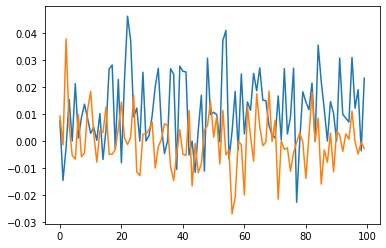

In [13]:
plt.plot(orig[:100])
plt.plot(gen[:100])

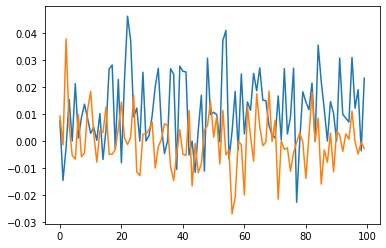

In [14]:
plt.plot(orig[:100])
plt.plot(gen[:100])

In [15]:
generated_np.shape

(208100, 489)